# Spotify Review NLP - Rating Prediction from Reviews on Google Play

The data was retrieved from https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022

This project aims at building an NLP machine that predicts the rating of the Spotify app based on the user reviews. A recurrent neural network will be used. Side information such as the number of upvotes and the time of publication will also be used as features.

The recently included TextVectorization layer has been used to build the model, incorporating data preprocessing steps during training time.

### EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv('reviews.csv')

In [3]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [4]:
df.shape

(61594, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [6]:
df.describe()

,Rating,Total_thumbsup
count,61594.000000,61594.000000
mean,3.155989,7.649381
std,1.673285,89.323143
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8195.000000


The mean of total upvotes of reviews grouped by the presence of replies

In [7]:
x = pd.concat((df['Total_thumbsup'], (df['Reply'].isna() == False).astype('str')), axis=1)
y = x.groupby('Reply')['Total_thumbsup'].mean()

Text(0, 0.5, 'Mean number of Upvotes')

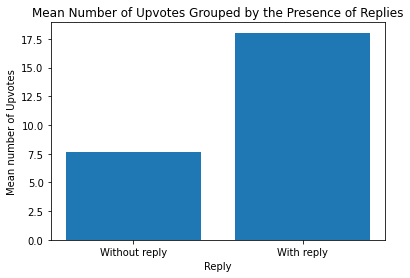

In [8]:
plt.bar(['Without reply', 'With reply'], y.values)
plt.title('Mean Number of Upvotes Grouped by the Presence of Replies')
plt.xlabel('Reply')
plt.ylabel('Mean number of Upvotes')

Distribution of ratings and the distribution of the number of upvotes

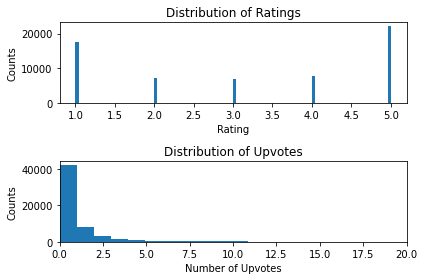

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.hist(df['Rating'].values, bins=100)
ax1.set_title('Distribution of Ratings')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Counts')
ax2 = fig.add_subplot(212)
ax2.hist(df['Total_thumbsup'][df['Total_thumbsup'] < 100].values, bins=100)
ax2.set_title('Distribution of Upvotes')
ax2.set_xlabel('Number of Upvotes')
ax2.set_ylabel('Counts')
ax2.set_xlim(0,20)
plt.tight_layout()
plt.show()

In [10]:
df['Total_thumbsup'].max()

8195

In [11]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'], format='%Y-%m-%d %H:%M:%S')

In [12]:
group_month = df.groupby(df['Time_submitted'].dt.month)

In [13]:
review_count_by_month = group_month['Rating'].count()

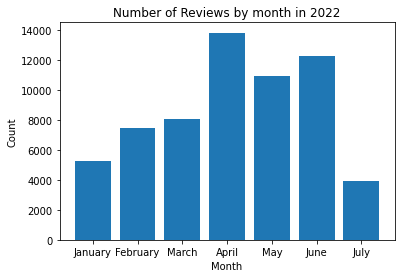

In [14]:
plt.bar(review_count_by_month.index, review_count_by_month.values)
plt.gca().set_xticks([1,2,3,4,5,6,7], ['January', 'February', 'March', 'April', 'May', 'June', 'July'])
plt.title('Number of Reviews by month in 2022')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

### Preprocessing

Lower Case

In [15]:
df['Review'] = df['Review'].str.lower()

Remove Punctuations

In [16]:
df['Review'] = df['Review'].str.replace('[^\w ]+', '', regex=True)

Remove stop words (Stop words are words that occur frequently but do not add much meaning to the sentence e.g. the, and, herself etc.)

In [24]:
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()

nltk.download('stopwords')

def remove_stop_words(sentence):
    new_words = []
    for word in sentence.split():
        if word not in stopwords.words('english'):
            new_words.append(word)
    return " ".join(new_words)

df['Review'] = df['Review'].progress_apply(remove_stop_words)

[nltk_data] Downloading package stopwords to C:\Users\Oscar
[nltk_data]     Wong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 61594/61594 [31:40<00:00, 32.42it/s]  


In [26]:
from collections import Counter

group_rating = df.groupby('Rating')

most_commons = []

for i in range(1,6):
    review_split_temp = group_rating.get_group(i)['Review'].str.lower().str.replace('[^\w ]+', '', regex=True).apply(lambda x: x.split())
    c = Counter()
    for x in review_split_temp:
        c.update(x)
    most_commons.append(c.most_common(200))

most_commons

[[('app', 11598),
  ('song', 5915),
  ('songs', 5706),
  ('spotify', 5439),
  ('music', 5418),
  ('play', 5092),
  ('cant', 4482),
  ('even', 3469),
  ('premium', 3268),
  ('listen', 2939),
  ('ads', 2897),
  ('playing', 2861),
  ('dont', 2731),
  ('update', 2659),
  ('im', 2526),
  ('playlist', 2435),
  ('want', 2426),
  ('like', 2368),
  ('fix', 2183),
  ('get', 2063),
  ('doesnt', 1879),
  ('time', 1872),
  ('every', 1764),
  ('use', 1729),
  ('one', 1623),
  ('please', 1595),
  ('phone', 1588),
  ('back', 1517),
  ('wont', 1402),
  ('stop', 1384),
  ('work', 1297),
  ('still', 1297),
  ('account', 1253),
  ('pay', 1226),
  ('new', 1215),
  ('keeps', 1200),
  ('ive', 1172),
  ('many', 1161),
  ('also', 1137),
  ('good', 1111),
  ('plays', 1021),
  ('free', 1020),
  ('without', 1014),
  ('really', 1009),
  ('skip', 977),
  ('way', 972),
  ('annoying', 965),
  ('used', 960),
  ('would', 952),
  ('podcasts', 941),
  ('go', 933),
  ('listening', 926),
  ('let', 907),
  ('working', 905),

Lemmatization

In [85]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

lm = WordNetLemmatizer()

def lemmatize(sentence):
    new_words = []
    words = sentence.split(' ')
    for word in words:
        new_words.append(lm.lemmatize(word))
    return ' '.join(new_words)

df['Review'] = df['Review'].apply(lemmatize)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [86]:
X_full = df['Review'].values
y_full = df['Rating'].values

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.1, random_state=42)

In [94]:
import tensorflow as tf
from tensorflow import keras

In [95]:
vector_layer = keras.layers.TextVectorization(5000)
vector_layer.adapt(X_train)
vocab_size = len(vector_layer.get_vocabulary())
print(vocab_size)

5000


In [99]:
embed_size = 128
model = keras.models.Sequential([
    vector_layer,
    keras.layers.Embedding(5000, embed_size,
                           mask_zero = True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True, kernel_regularizer='l2'),
    keras.layers.LayerNormalization(),
    keras.layers.GRU(128, kernel_regularizer='l2'),
    keras.layers.Dense(1)
])

In [100]:
cb_earlystop = keras.callbacks.EarlyStopping(patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', metrics=tf.keras.metrics.RootMeanSquaredError(), optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=40, validation_data=[X_valid, y_valid], callbacks=[cb_earlystop])

Epoch 1/40
1733/1733 [==============================] - 91s 21ms/step - loss: 1.5324 - root_mean_squared_error: 1.0652 - val_loss: 1.0369 - val_root_mean_squared_error: 0.9863
Epoch 2/40
1733/1733 [==============================] - 34s 20ms/step - loss: 0.9425 - root_mean_squared_error: 0.9451 - val_loss: 0.9901 - val_root_mean_squared_error: 0.9733
Epoch 3/40
1733/1733 [==============================] - 36s 20ms/step - loss: 0.8660 - root_mean_squared_error: 0.9087 - val_loss: 0.9650 - val_root_mean_squared_error: 0.9625
Epoch 4/40
1733/1733 [==============================] - 35s 20ms/step - loss: 0.8134 - root_mean_squared_error: 0.8803 - val_loss: 0.9452 - val_root_mean_squared_error: 0.9553
Epoch 5/40
1733/1733 [==============================] - 34s 20ms/step - loss: 0.7720 - root_mean_squared_error: 0.8573 - val_loss: 1.0041 - val_root_mean_squared_error: 0.9861
Epoch 6/40
1733/1733 [==============================] - 34s 20ms/step - loss: 0.7418 - root_mean_squared_error: 0.8402 -

In [101]:
df_fit = pd.DataFrame(history.history)

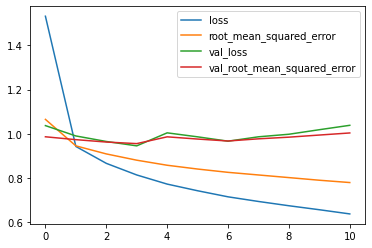

In [102]:
df_fit.plot()

In [103]:
model.predict(['This app is so good'])

array([[4.9268956]], dtype=float32)

In [104]:
model.predict(['This app is not bad'])

array([[1.6854765]], dtype=float32)

In [105]:
model.predict(['terrible app'])

array([[0.44108278]], dtype=float32)